# Max Min Fairness

Here we try to implement the max min fairness idea. That means we try to maximize the minimal group utility by ensuring that for all groups the average utility of that group is above a certain threshold

In [12]:
import numpy as np
import pandas as pd
from load_compas_data_modified import *
import funcs_disp_mist_modified as fdm
import matplotlib.pyplot as plt
import utils_modified as ut
from cvxpy import *
import ncvx
from scsprox import Prox

### Defining some functions

We have to define a utility function. In this case we assume the output is either -1 or 1, therefore the following utlity is eiher 2,0 or -2

In [13]:
def avg_utility(y_pred, y_actual,alpha):
    #assert(y_pred.shape[0] == y.shape[0])
    n = y_actual.shape[0]
    s = sum_entries(power(((y_pred-y_actual)+10),alpha))
    return s/n 
def eval_util(y_pred, y_actual, alpha):
    n = y_actual.shape[0]
    s = np.sum(np.power((np.subtract(y_pred,y_actual)+10),alpha))
    return s/n 

## Importing the COMPAS dataset

Here we import the COMPAS dataset. It is preprocessed the same way as in the ProPublica study (refer to https://github.com/propublica/compas-analysis)

In [9]:
#data_type = 1
X, y, x_control = load_compas_data()

Looking for file 'compas-scores-two-years.csv' in the current directory...
File found in current directory..

Number of people recidivating within two years
-1    2795
 1    2483
dtype: int64


Features we will be using for classification are: ['intercept', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree'] 



## Train the utility model

In [10]:
"""permute the data randomly"""
perm = list(range(0,X.shape[0]))
shuffle(perm)
X = X[perm]
y = y[perm]
#for k in list(x_control.keys()):
for k in x_control.keys():
    x_control[k] = x_control[k][perm]

""" Split the data into train and test """
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)


In [11]:
sensitive_attrs = list(x_control.keys())


# set the alpha parameter for our utility function
alpha = 0.5

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6 # tolerance parameter for the optimizer
loss_function = "logreg" # perform the experiments with logistic regression

num_points, num_features = x_train.shape

# initialize a random value of the weight vectors
w_uncons = Variable(num_features)
w_uncons.value = np.random.rand(x_train.shape[1])
w_cons = Variable(num_features)
w_cons.value = np.random.rand(x_train.shape[1])


# train an unconstrained classifier for reference
w_uncons = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)


train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_uncons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

util_uncons = eval_util((np.dot(x_train, w_uncons)), y_train,alpha)
print("Utility without constraints: " + str(util_uncons) + "\n")

        
# threshold that average utility needs to be above, called epsilon in the plots  
threshold = 5
y_pred = (x_train*w_cons)

# logistic loss
loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

group_array_train = x_control_train['race']
# need to split predictions into groups to compute utility separately
group0_filter = np.invert(group_array_train.astype(bool))
group1_filter = group_array_train.astype(bool)

y_pred1 = y_pred[group1_filter]
y_pred0 = y_pred[group0_filter]
y_train1 = y_train[group1_filter]
y_train0 = y_train[group0_filter]

util1 = avg_utility(y_pred1, y_train1, alpha)
util0 = avg_utility(y_pred0, y_train0, alpha)

# utility for both groups needs to be above threshold
# w constrained to not allow arbitrary utlity increase by scaling
constraints = [threshold <= util1, threshold <= util0, w_cons <= 10]

prob = Problem(Minimize(loss), constraints)

tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset


try:
    prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
            solver=ECOS, verbose=False,
            max_iters=max_iters, max_iter=max_iter_dccp)
except Exception as e:
    print (e)

#convert solution vector to a numpy array
w_cons = np.array(w_cons.value).flatten()

# achieved utilities of constrained classifier
util_cons1 = eval_util(np.dot(x_train,w_cons)[group1_filter], y_train1, alpha)
util_cons0 = eval_util(np.dot(x_train,w_cons)[group0_filter], y_train0, alpha)

train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

print("Utility with constraints for group 1: " + str(util_cons1) + "\n")
print("Utility with constraints for group 0: " + str(util_cons0) + "\n")

[ 1. -1. -1. ... -1. -1.  1.]


Accuracy: 0.667
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.30 ||
||  1  || 0.13 || 0.66 ||


Utility without constraints: 3.1441477305856353

[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.484
||  s  || FPR. || FNR. ||
||  0  || 0.96 || 0.01 ||
||  1  || 1.00 || 0.00 ||


Utility with constraints for group 1: 5.00000000109123

Utility with constraints for group 0: 5.000000001535987



## Behavior of accuracy when varying parameters

### Accuracy vs. Epsilon

Notes: 
    - utility for unconstrained is around 9.90 for group 1 and 9.96 for group 0 (for alpha = 1)
    - when increasing the threshold both utilities are more or less exactly on the threshold
    - at a threshold of 40, all samples were classified as positive
    - for alpha=1 the scanned region of thresholds was therefore 9-40
    - for alpha=0.5 it was 3-6 for the same reasons
    - w element-wise constrained to be smaller equal 10

In [47]:
sensitive_attrs = list(x_control.keys())

# how many equispaced threshold values to try within the range specified later 
threshold_iter = 30
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0.5

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 0
# array of all threshold values to try, range needs to be specified such that on the lower end
#  the classifier behaves as if unconstrained and on the upper end it has to classify all data points
#  positively
threshold_array = np.linspace(3,6,threshold_iter)
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(threshold_iter)
loss_array = np.zeros(threshold_iter)

for j in range(0,threshold_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    threshold = threshold_array[j]
    
    accuracy = 0
    l = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)
        
        group_array_train = x_control_train['race']
        # need to split predictions into groups to compute utility separately
        group0_filter = np.invert(group_array_train.astype(bool))
        group1_filter = group_array_train.astype(bool)

        y_pred1 = y_pred[group1_filter]
        y_pred0 = y_pred[group0_filter]
        y_train1 = y_train[group1_filter]
        y_train0 = y_train[group0_filter]

        util1 = avg_utility(y_pred1, y_train1, alpha)
        util0 = avg_utility(y_pred0, y_train0, alpha)
        

        
        # utility for both groups needs to be above threshold
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util1, threshold <= util0, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()
        print(prob.status)

        # achieved utilities of constrained classifier
        util_cons1 = eval_util(np.dot(x_train,w_cons)[group1_filter], y_train1, alpha)
        util_cons0 = eval_util(np.dot(x_train,w_cons)[group0_filter], y_train0, alpha)

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        print(test_score)
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        print("Utility with constraints for group 1: " + str(util_cons1) + "\n")
        print("Utility with constraints for group 0: " + str(util_cons0) + "\n")
    accuracy_array[j] = accuracy / cross_val_iter
    loss_array[j] = l / cross_val_iter
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
Converged
[-1.  1. -1. ..., -1. -1. -1.]


Accuracy: 0.655
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.30 ||
||  1  || 0.16 || 0.66 ||


0.6552097428958051
Utility with constraints for group 1: 3.15473901483

Utility with constraints for group 0: 3.14340292307

#############cross validation iteration 1 #########################
None
Converged
[-1. -1.  1. ...,  1.  1.  1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.31 ||
||  1  || 0.20 || 0.52 ||


0.6706359945872801
Utility with constraints for group 1: 3.15132813545

Utility with constraints for group 0: 3.16128907941

#############cross validation iteration 2 #########################
None
Converged
[-1. -1. -1. ..., -1. -1.  1.]


Accuracy: 0.662
||  s  || FPR. || FNR. ||
||  0  || 0.31 || 0.35 ||
||  1  || 0.07 || 0.75 ||


0.6622462787550745
Utility with constraints for

||  1  || 0.74 || 0.10 ||


0.557510148849797
Utility with constraints for group 1: 3.41379310349

Utility with constraints for group 0: 3.4332975823

#############cross validation iteration 3 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.543
||  s  || FPR. || FNR. ||
||  0  || 0.89 || 0.03 ||
||  1  || 0.74 || 0.07 ||


0.5434370771312584
Utility with constraints for group 1: 3.41379310347

Utility with constraints for group 0: 3.41759461938

#############cross validation iteration 4 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.542
||  s  || FPR. || FNR. ||
||  0  || 0.89 || 0.03 ||
||  1  || 0.75 || 0.07 ||


0.5415426251691475
Utility with constraints for group 1: 3.41379310353

Utility with constraints for group 0: 3.41974060692

########Test accuracy: 2.6995940460081194 (for threshold iteration) 4 ############

#############Threshold value iteration 5 #########################
#############cross valid

Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.521
||  s  || FPR. || FNR. ||
||  0  || 0.97 || 0.01 ||
||  1  || 0.77 || 0.08 ||


0.520703653585927
Utility with constraints for group 1: 3.93174988676

Utility with constraints for group 0: 3.93103448281

#############cross validation iteration 1 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.512
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.83 || 0.04 ||


0.5115020297699594
Utility with constraints for group 1: 3.93103448282

Utility with constraints for group 0: 3.98068686749

#############cross validation iteration 2 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.530
||  s  || FPR. || FNR. ||
||  0  || 0.93 || 0.02 ||
||  1  || 0.78 || 0.05 ||


0.5301759133964817
Utility with constraints for group 1: 3.94031557138

Utility with constraints for group 0: 3.93103448299

#############cross validation iteration 3 #####################

Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.501
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.84 || 0.05 ||


0.5009472259810555
Utility with constraints for group 1: 4.41542684847

Utility with constraints for group 0: 4.34482758645

#############cross validation iteration 4 #########################
None
Converged
[ 1.  1. -1. ...,  1.  1.  1.]


Accuracy: 0.500
||  s  || FPR. || FNR. ||
||  0  || 0.98 || 0.01 ||
||  1  || 0.88 || 0.03 ||


0.49986468200270634
Utility with constraints for group 1: 4.34482758666

Utility with constraints for group 0: 4.37807028777

########Test accuracy: 2.4982408660351827 (for threshold iteration) 13 ############

#############Threshold value iteration 14 #########################
#############cross validation iteration 0 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.503
||  s  || FPR. || FNR. ||
||  0  || 0.98 || 0.01 ||
||  1  || 0.89 || 0.03 ||


0.5031123139377537
Utility with c



0.48497970230040593
Utility with constraints for group 1: 4.86206896646

Utility with constraints for group 0: 4.86206896665

#############cross validation iteration 1 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.476
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.95 || 0.02 ||


0.4760487144790257
Utility with constraints for group 1: 4.88833003806

Utility with constraints for group 0: 4.862068966

#############cross validation iteration 2 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.473
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.99 || 0.01 ||


0.47280108254397835
Utility with constraints for group 1: 4.86206896599

Utility with constraints for group 0: 4.88823514357

#############cross validation iteration 3 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.476
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.95 

Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.479
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.97 || 0.01 ||


0.4790257104194858
Utility with constraints for group 1: 5.37893342471

Utility with constraints for group 0: 5.27586207092

#############cross validation iteration 4 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.477
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.96 || 0.02 ||


0.4774018944519621
Utility with constraints for group 1: 5.27586206951

Utility with constraints for group 0: 5.2758620757

########Test accuracy: 2.3975642760487146 (for threshold iteration) 22 ############

#############Threshold value iteration 23 #########################
#############cross validation iteration 0 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.482
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.95 || 0.01 ||


0.48200270635994585
Utility with co



0.47794316644113666
Utility with constraints for group 1: 5.81037636619

Utility with constraints for group 0: 5.79310345228

#############cross validation iteration 1 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.470
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


0.47036535859269285
Utility with constraints for group 1: 5.79310344938

Utility with constraints for group 0: 5.82090414518

#############cross validation iteration 2 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.475
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.97 || 0.01 ||


0.4752368064952639
Utility with constraints for group 1: 5.79310344917

Utility with constraints for group 0: 5.81421372938

#############cross validation iteration 3 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.468
||  s  || FPR. || FNR. ||
||  0  || 0.98 || 0.00 ||
||  1  || 1.0

### Accuracy vs Alpha

We set epsilon to 5 and vary alpha between 0.45 and 1, for lower alpha values the solver fails

In [49]:
sensitive_attrs = list(x_control.keys())

# how many equispaced threshold values to try within the range specified later 
alpha_iter = 15
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0.5
# specify range for alpha parameters to try
alpha_array = np.linspace(0.45,1,alpha_iter)

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 5
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(alpha_iter)
loss_array = np.zeros(alpha_iter)

for j in range(0,alpha_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    alpha = alpha_array[j]   
    
    accuracy = 0
    l = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)
        
        # need to split predictions into groups to compute utility separately
        group_array_train = x_control_train['race']
        group0_filter = np.invert(group_array_train.astype(bool))
        group1_filter = group_array_train.astype(bool)

        y_pred1 = y_pred[group1_filter]
        y_pred0 = y_pred[group0_filter]
        y_train1 = y_train[group1_filter]
        y_train0 = y_train[group0_filter]

        util1 = avg_utility(y_pred1, y_train1, alpha)
        util0 = avg_utility(y_pred0, y_train0, alpha)
        

        
        # utility for both groups needs to be above threshold
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util1, threshold <= util0, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()
        print(prob.status)

        # achieved utilities of constrained classifier
        util_cons1 = eval_util(np.dot(x_train,w_cons)[group1_filter], y_train1, alpha)
        util_cons0 = eval_util(np.dot(x_train,w_cons)[group0_filter], y_train0, alpha)

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        print(test_score)
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        print("Utility with constraints for group 1: " + str(util_cons1) + "\n")
        print("Utility with constraints for group 0: " + str(util_cons0) + "\n")
    accuracy_array[j] = accuracy / cross_val_iter
    loss_array[j] = l / cross_val_iter
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.466
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


0.46576454668470907
Utility with constraints for group 1: 5.00000000593

Utility with constraints for group 0: 5.00236004935

#############cross validation iteration 1 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.476
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


0.476319350473613
Utility with constraints for group 1: 5.00000000754

Utility with constraints for group 0: 5.00644658693

#############cross validation iteration 2 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.459
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


0.4592692828146143
Utility with constraints for



0.4979702300405954
Utility with constraints for group 1: 5.0193445375

Utility with constraints for group 0: 5.00000001231

#############cross validation iteration 3 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.490
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.90 || 0.04 ||


0.49039242219215157
Utility with constraints for group 1: 5.18327931258

Utility with constraints for group 0: 5.00000001344

#############cross validation iteration 4 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.492
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.92 || 0.02 ||


0.49174560216508795
Utility with constraints for group 1: 5.00000000833

Utility with constraints for group 0: 5.03725463059

########Test accuracy: 2.453044654939107 (for threshold iteration) 4 ############

#############Threshold value iteration 5 #########################
#############cross validation iteration 0 ######

Converged
[ 1.  1.  1. ..., -1. -1.  1.]


Accuracy: 0.529
||  s  || FPR. || FNR. ||
||  0  || 0.92 || 0.02 ||
||  1  || 0.80 || 0.05 ||


0.5293640054127199
Utility with constraints for group 1: 5.00000000065

Utility with constraints for group 0: 5.00000001584

#############cross validation iteration 1 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.512
||  s  || FPR. || FNR. ||
||  0  || 0.96 || 0.02 ||
||  1  || 0.79 || 0.06 ||


0.5115020297699594
Utility with constraints for group 1: 5.00000000128

Utility with constraints for group 0: 5.05302711087

#############cross validation iteration 2 #########################
None
Converged
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.542
||  s  || FPR. || FNR. ||
||  0  || 0.89 || 0.03 ||
||  1  || 0.76 || 0.06 ||


0.5423545331529094
Utility with constraints for group 1: 5.00000000104

Utility with constraints for group 0: 5.0197688049

#############cross validation iteration 3 #####################

Converged
[ 1.  1. -1. ...,  1.  1.  1.]


Accuracy: 0.670
||  s  || FPR. || FNR. ||
||  0  || 0.40 || 0.26 ||
||  1  || 0.20 || 0.55 ||


0.669553450608931
Utility with constraints for group 1: 5.01206101548

Utility with constraints for group 0: 5.00000026007

#############cross validation iteration 4 #########################
None
Combined backtracking failed 0 0 0 90 sigma 1
Combined backtracking failed 0 0 0 90 sigma 1
Converged
[ 1. -1.  1. ...,  1.  1. -1.]


Accuracy: 0.670
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.29 ||
||  1  || 0.19 || 0.57 ||


0.669553450608931
Utility with constraints for group 1: 5.02589739587

Utility with constraints for group 0: 5.00000031211

########Test accuracy: 3.3353179972936404 (for threshold iteration) 13 ############

#############Threshold value iteration 14 #########################
#############cross validation iteration 0 #########################
None
Converged
[-1. -1.  1. ...,  1. -1.  1.]


Accuracy: 0.666
||  s  || FPR. || FNR. |

Converged
[-1. -1. -1. ...,  1.  1. -1.]


Accuracy: 0.665
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.30 ||
||  1  || 0.17 || 0.61 ||


0.6646820027063599
Utility with constraints for group 1: 6.18338249397

Utility with constraints for group 0: 6.17219862016

#############cross validation iteration 1 #########################
None
Converged
[ 1.  1. -1. ..., -1.  1. -1.]


Accuracy: 0.654
||  s  || FPR. || FNR. ||
||  0  || 0.32 || 0.37 ||
||  1  || 0.14 || 0.65 ||


0.6541271989174561
Utility with constraints for group 1: 6.12113465902

Utility with constraints for group 0: 6.1125777923

#############cross validation iteration 2 #########################
None
Converged
[-1. -1.  1. ..., -1. -1.  1.]


Accuracy: 0.675
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.27 ||
||  1  || 0.21 || 0.54 ||


0.6749661705006766
Utility with constraints for group 1: 6.21948148292

Utility with constraints for group 0: 6.17147968346

#############cross validation iteration 3 #####################

Converged
[-1. -1.  1. ..., -1.  1. -1.]


Accuracy: 0.642
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.34 ||
||  1  || 0.21 || 0.60 ||


0.6416779431664411
Utility with constraints for group 1: 7.32704272796

Utility with constraints for group 0: 7.31541324277

#############cross validation iteration 4 #########################
None
Converged
[ 1. -1. -1. ..., -1.  1.  1.]


Accuracy: 0.662
||  s  || FPR. || FNR. ||
||  0  || 0.33 || 0.34 ||
||  1  || 0.15 || 0.63 ||


0.6617050067658998
Utility with constraints for group 1: 7.32618719627

Utility with constraints for group 0: 7.31116511418

########Test accuracy: 3.2963464140730716 (for threshold iteration) 22 ############

#############Threshold value iteration 23 #########################
#############cross validation iteration 0 #########################
None
Converged
[-1.  1. -1. ...,  1.  1.  1.]


Accuracy: 0.661
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.30 ||
||  1  || 0.13 || 0.68 ||


0.6611637347767253
Utility with co



0.6711772665764547
Utility with constraints for group 1: 9.14350349572

Utility with constraints for group 0: 9.16257359606

#############cross validation iteration 1 #########################
None
Converged
[-1. -1.  1. ..., -1.  1.  1.]


Accuracy: 0.663
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.30 ||
||  1  || 0.18 || 0.59 ||


0.6633288227334235
Utility with constraints for group 1: 9.12172483844

Utility with constraints for group 0: 9.16147279076

#############cross validation iteration 2 #########################
None
Converged
[ 1.  1. -1. ..., -1. -1. -1.]


Accuracy: 0.672
||  s  || FPR. || FNR. ||
||  0  || 0.31 || 0.34 ||
||  1  || 0.15 || 0.61 ||


0.6719891745602166
Utility with constraints for group 1: 9.14170875004

Utility with constraints for group 0: 9.11416674895

#############cross validation iteration 3 #########################
None
Converged
[ 1. -1.  1. ..., -1. -1.  1.]


Accuracy: 0.657
||  s  || FPR. || FNR. ||
||  0  || 0.32 || 0.35 ||
||  1  || 0.15 

In [ ]:
Now we plot accuracy vs the parameter we are varying (epsilon or alpha)

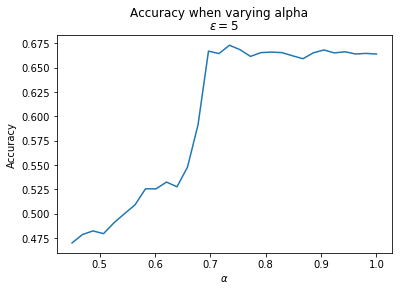

In [52]:
plt.plot(alpha_array, accuracy_array)
plt.suptitle('Accuracy when varying alpha')
plt.title('$\epsilon = 5$')
plt.ylabel('Accuracy')
plt.xlabel('$\\alpha$')
plt.show()

## Now we look at how other fairness measures behave when we vary our parameters

### Demographic parity and Equality of Opportunity when varying epsilon

In [57]:
# group 1 is white, group 0 is black

# we look at the outcome in the test set



sensitive_attrs = list(x_control.keys())

# how many equispaced threshold values to try within the range specified later 
threshold_iter = 30
# how many cross validation iterations
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0.5

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 0

# array of all threshold values to try, range needs to be specified such that on the lower end
#  the classifier behaves as if unconstrained and on the upper end it has to classify all data points
#  positively
threshold_array = np.linspace(3,6,threshold_iter)
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(threshold_iter)
loss_array = np.zeros(threshold_iter)
# holds percentages of positive predictions for both groups w.r.t. demographic parity
pc0_DP_array = np.zeros(threshold_iter)
pc1_DP_array = np.zeros(threshold_iter)
# holds percentages of positive predictions for both groups w.r.t. equality of opportunity
pc0_EO_array = np.zeros(threshold_iter)
pc1_EO_array = np.zeros(threshold_iter)


for j in range(0,threshold_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    threshold = threshold_array[j]
    
    accuracy = 0
    l = 0
    pc0_DP = 0
    pc1_DP = 0
    pc0_EO = 0
    pc1_EO = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape
    

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)
        
        # need to split predictions into groups to compute utility separately
        group_array_train = x_control_train['race']
        group0_filter = np.invert(group_array_train.astype(bool))
        group1_filter = group_array_train.astype(bool)

        y_pred1 = y_pred[group1_filter]
        y_pred0 = y_pred[group0_filter]
        y_train1 = y_train[group1_filter]
        y_train0 = y_train[group0_filter]

        util1 = avg_utility(y_pred1, y_train1, alpha)
        util0 = avg_utility(y_pred0, y_train0, alpha)
        

        
        # utility for both groups needs to be above threshold
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util1, threshold <= util0, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        
        group_array_test = x_control_test['race']
        # total number of data points
        n = y_test.shape[0]
        unique, counts = np.unique(group_array_test, return_counts=True)
        # number of people in group 0
        n0 = counts[0]
        # number of people in group 1
        n1 = counts[1]
        
        y_pred = np.sign(np.dot(x_test,w_cons))
        
        # positive prediction count for both classes and for predicted labels
        pos_count0_actual = 0
        pos_count1_actual = 0 
        pos_count0_pred = 0
        pos_count1_pred = 0

        # demographic parity check
        counter = 0
        for group_membership in group_array_test:
            if group_membership == 1:
                if y_test[counter] == 1:
                    pos_count1_actual += 1
                if y_pred[counter] == 1:
                    pos_count1_pred += 1
            elif group_membership == 0:
                if y_test[counter] == 1:
                    pos_count0_actual += 1
                if y_pred[counter] == 1:
                    pos_count0_pred += 1
            else:
                print("ERROR")
            counter += 1


        
        pc0_DP += pos_count0_pred/n0
        pc1_DP += pos_count1_pred/n1
        
        pos_count0_pred = 0
        pos_count1_pred = 0
        
        # equality of opportunity check
        counter = 0
        for group_membership in group_array_test:
            if group_membership == 1:
                if y_test[counter] == 1:
                    if y_pred[counter] == 1:
                        pos_count1_pred += 1
            elif group_membership == 0:
                if y_test[counter] == 1:
                    if y_pred[counter] == 1:
                        pos_count0_pred += 1
            else:
                print("ERROR")
            counter += 1
        
        pc0_EO += pos_count0_pred/pos_count0_actual
        pc1_EO += pos_count1_pred/pos_count1_actual
        
        
    accuracy_array[j] = accuracy / cross_val_iter
    loss_array[j] = l / cross_val_iter
    pc0_DP_array[j] = pc0_DP / cross_val_iter
    pc1_DP_array[j] = pc1_DP / cross_val_iter
    pc0_EO_array[j] = pc0_EO / cross_val_iter
    pc1_EO_array[j] = pc1_EO / cross_val_iter
    print("########Test accuracy: " + str(accuracy/ cross_val_iter) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[ 1. -1. -1. ..., -1.  1. -1.]


Accuracy: 0.663
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.33 ||
||  1  || 0.13 || 0.64 ||


#############cross validation iteration 1 #########################
None
[-1. -1. -1. ...,  1. -1. -1.]


Accuracy: 0.668
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.30 ||
||  1  || 0.12 || 0.68 ||


#############cross validation iteration 2 #########################
None
[-1. -1. -1. ..., -1. -1.  1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.26 ||
||  1  || 0.18 || 0.59 ||


#############cross validation iteration 3 #########################
None
[-1.  1. -1. ...,  1.  1. -1.]


Accuracy: 0.669
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.31 ||
||  1  || 0.19 || 0.55 ||


#############cross validation iteration 4 #########################
None
[-1. -1. -1. ..., -1.  1.  1.]


Accuracy: 0.664
|| 

[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.507
||  s  || FPR. || FNR. ||
||  0  || 0.82 || 0.06 ||
||  1  || 0.97 || 0.01 ||


#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.522
||  s  || FPR. || FNR. ||
||  0  || 0.74 || 0.08 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 2 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.514
||  s  || FPR. || FNR. ||
||  0  || 0.81 || 0.06 ||
||  1  || 0.95 || 0.02 ||


#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ..., -1.  1.  1.]


Accuracy: 0.503
||  s  || FPR. || FNR. ||
||  0  || 0.86 || 0.03 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ..., -1.  1.  1.]


Accuracy: 0.502
||  s  || FPR. || FNR. ||
||  0  || 0.83 || 0.05 ||
||  1  || 1.00 || 0.00 ||


########Test accuracy: 0.5099323410013532 (for threshold iterat

||  0  || 0.86 || 0.04 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.489
||  s  || FPR. || FNR. ||
||  0  || 0.91 || 0.03 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 2 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.490
||  s  || FPR. || FNR. ||
||  0  || 0.88 || 0.04 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.492
||  s  || FPR. || FNR. ||
||  0  || 0.92 || 0.02 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.496
||  s  || FPR. || FNR. ||
||  0  || 0.87 || 0.03 ||
||  1  || 1.00 || 0.00 ||


########Test accuracy: 0.49239512855209744 (for threshold iteration) 14 ############

#############Threshold value iteration 15 ##########

[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.481
||  s  || FPR. || FNR. ||
||  0  || 0.96 || 0.01 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 2 #########################
None
[-1.  1.  1. ...,  1. -1.  1.]


Accuracy: 0.484
||  s  || FPR. || FNR. ||
||  0  || 0.97 || 0.01 ||
||  1  || 0.96 || 0.01 ||


#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.475
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.473
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 1.00 || 0.00 ||


########Test accuracy: 0.4781596752368065 (for threshold iteration) 21 ############

#############Threshold value iteration 22 #########################
#############cross validation iteration 0 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accura



#############cross validation iteration 2 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.467
||  s  || FPR. || FNR. ||
||  0  || 0.98 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.474
||  s  || FPR. || FNR. ||
||  0  || 0.98 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.467
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 1.00 || 0.00 ||


########Test accuracy: 0.47269282814614344 (for threshold iteration) 28 ############

#############Threshold value iteration 29 #########################
#############cross validation iteration 0 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.473
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iterat

### Demographic parity and Equality of Opportunity when varying alpha

In [6]:
# need to split predictions into different groups
# for demographic parity, only need to look at positive prediction percentage of the two groups
# group 1 is white, group 0 is black

# we look at the outcome in the test set



sensitive_attrs = list(x_control.keys())

# how many equispaced alpha values to try within the range specified later 
alpha_iter = 15
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0
# specify range for alpha parameters to try
alpha_array = np.linspace(0.45,1,alpha_iter)


# set the alpha parameter for our utility
alpha = 0.5

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 5
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(alpha_iter)
loss_array = np.zeros(alpha_iter)
# holds percentages of positive predictions for both groups w.r.t. demographic parity
pc0_DP_array = np.zeros(alpha_iter)
pc1_DP_array = np.zeros(alpha_iter)
# holds percentages of positive predictions for both groups w.r.t. equality of opportunity
pc0_EO_array = np.zeros(alpha_iter)
pc1_EO_array = np.zeros(alpha_iter)


for j in range(0,alpha_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    alpha = alpha_array[j]
    
    accuracy = 0
    l = 0
    pc0_DP = 0
    pc1_DP = 0
    pc0_EO = 0
    pc1_EO = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape
    

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)
        
        # need to split predictions into groups to compute utility separately
        group_array_train = x_control_train['race']
        group0_filter = np.invert(group_array_train.astype(bool))
        group1_filter = group_array_train.astype(bool)

        y_pred1 = y_pred[group1_filter]
        y_pred0 = y_pred[group0_filter]
        y_train1 = y_train[group1_filter]
        y_train0 = y_train[group0_filter]

        util1 = avg_utility(y_pred1, y_train1, alpha)
        util0 = avg_utility(y_pred0, y_train0, alpha)
        

        
        # utility for both groups needs to be above threshold
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util1, threshold <= util0, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        
        group_array_test = x_control_test['race']
        # total number of data points
        n = y_test.shape[0]
        unique, counts = np.unique(group_array_test, return_counts=True)
        # number of people in group 0
        n0 = counts[0]
        # number of people in group 1
        n1 = counts[1]
        
        y_pred = np.sign(np.dot(x_test,w_cons))
        
        # positive prediction count for both classes and for predicted labels
        pos_count0_actual = 0
        pos_count1_actual = 0 
        pos_count0_pred = 0
        pos_count1_pred = 0

        # demographic parity check
        counter = 0
        for group_membership in group_array_test:
            if group_membership == 1:
                if y_test[counter] == 1:
                    pos_count1_actual += 1
                if y_pred[counter] == 1:
                    pos_count1_pred += 1
            elif group_membership == 0:
                if y_test[counter] == 1:
                    pos_count0_actual += 1
                if y_pred[counter] == 1:
                    pos_count0_pred += 1
            else:
                print("ERROR")
            counter += 1


        
        pc0_DP += pos_count0_pred/n0
        pc1_DP += pos_count1_pred/n1
        
        pos_count0_pred = 0
        pos_count1_pred = 0
        
        # equality of opportunity check
        counter = 0
        for group_membership in group_array_test:
            if group_membership == 1:
                if y_test[counter] == 1:
                    if y_pred[counter] == 1:
                        pos_count1_pred += 1
            elif group_membership == 0:
                if y_test[counter] == 1:
                    if y_pred[counter] == 1:
                        pos_count0_pred += 1
            else:
                print("ERROR")
            counter += 1
        
        pc0_EO += pos_count0_pred/pos_count0_actual
        pc1_EO += pos_count1_pred/pos_count1_actual
        
        
    accuracy_array[j] = accuracy / cross_val_iter
    loss_array[j] = l / cross_val_iter
    pc0_DP_array[j] = pc0_DP / cross_val_iter
    pc1_DP_array[j] = pc1_DP / cross_val_iter
    pc0_EO_array[j] = pc0_EO / cross_val_iter
    pc1_EO_array[j] = pc1_EO / cross_val_iter
    print("########Test accuracy: " + str(accuracy/ cross_val_iter) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.483
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.478
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 2 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.468
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.475
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.468
|| 

[ 1.  1. -1. ..., -1. -1.  1.]


Accuracy: 0.667
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.31 ||
||  1  || 0.20 || 0.57 ||


#############cross validation iteration 1 #########################
None
[ 1. -1.  1. ...,  1. -1.  1.]


Accuracy: 0.667
||  s  || FPR. || FNR. ||
||  0  || 0.33 || 0.34 ||
||  1  || 0.14 || 0.63 ||


#############cross validation iteration 2 #########################
None
[-1. -1. -1. ..., -1.  1. -1.]


Accuracy: 0.659
||  s  || FPR. || FNR. ||
||  0  || 0.27 || 0.41 ||
||  1  || 0.10 || 0.70 ||


#############cross validation iteration 3 #########################
None
[ 1. -1.  1. ...,  1.  1. -1.]


Accuracy: 0.663
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.29 ||
||  1  || 0.15 || 0.65 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1. -1.  1.]


Accuracy: 0.658
||  s  || FPR. || FNR. ||
||  0  || 0.41 || 0.28 ||
||  1  || 0.23 || 0.54 ||


########Test accuracy: 0.6625710419485792 (for threshold iterat



#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ..., -1.  1. -1.]


Accuracy: 0.660
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.30 ||
||  1  || 0.25 || 0.52 ||


#############cross validation iteration 2 #########################
None
[-1.  1. -1. ...,  1. -1. -1.]


Accuracy: 0.668
||  s  || FPR. || FNR. ||
||  0  || 0.39 || 0.27 ||
||  1  || 0.14 || 0.64 ||


#############cross validation iteration 3 #########################
None
[-1.  1.  1. ..., -1.  1. -1.]


Accuracy: 0.659
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.29 ||
||  1  || 0.21 || 0.59 ||


#############cross validation iteration 4 #########################
None
[-1.  1. -1. ..., -1. -1.  1.]


Accuracy: 0.665
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.30 ||
||  1  || 0.21 || 0.56 ||


########Test accuracy: 0.6630040595399188 (for threshold iteration) 14 ############



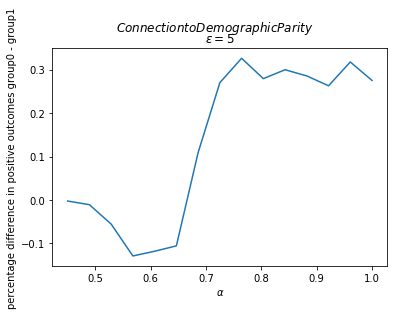

In [7]:
# we plot how the difference in positive predictions between groups changes as we vary alpha or epsilon
# demographic parity first
plt.plot(alpha_array, np.subtract(pc0_DP_array,pc1_DP_array))
plt.suptitle('$Connection to Demographic Parity$')
plt.title('$\epsilon = 5$')
plt.ylabel('percentage difference in positive outcomes group0 - group1')
plt.xlabel('$\\alpha$')
plt.show()

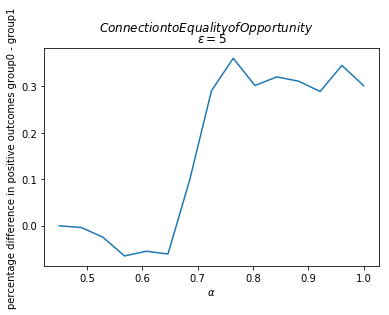

In [8]:
# we plot how the difference in positive predictions between groups changes as we vary alpha or epsilon
# equality of opportunity (meaning positive predictions conditioned on the actual label being positive)
plt.plot(alpha_array, np.subtract(pc0_EO_array,pc1_EO_array))
plt.suptitle('$Connection to Equality of Opportunity$')
plt.title('$\epsilon = 5$')
plt.ylabel('percentage difference in positive outcomes group0 - group1')
plt.xlabel('$\\alpha$')
plt.show()